In [2]:
!pip install catboost
!pip install XGBoost
from catboost import CatBoostRegressor
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error 
import matplotlib.pyplot as plt
import joblib

In [17]:
#загрузка датасетов для первой задачи
X = pd.read_excel('X.xlsx')
y1 = pd.read_excel('y1.xlsx')
y2 = pd.read_excel('y2.xlsx')

In [18]:
X.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.099781,0.625107,0.438928,0.912803,0.000000,0.711831,0.0000,0.555556,0,0.166667,0.000000
1,0.452019,0.625107,0.450658,0.584256,0.229622,0.416197,0.0000,0.555556,0,0.166667,0.434783
2,0.450704,0.538593,0.446546,0.584256,0.229622,0.416197,0.0000,0.555556,0,0.166667,0.565217
3,0.374299,0.279051,0.495066,0.584256,0.229622,0.416197,0.0000,0.555556,0,0.166667,1.000000
4,0.371161,0.250214,0.271382,0.584256,0.229622,0.416197,0.2125,0.000000,0,0.500000,0.000000


In [19]:
y1.head()

,"Модуль упругости при растяжении, ГПа"
0,70.0
1,70.0
2,70.0
3,70.0
4,75.0


In [20]:
y2.head()

,"Прочность при растяжении, МПа"
0,3000.0
1,3000.0
2,3000.0
3,3000.0
4,1800.0


In [21]:
#Определние тестовой и обучающей выборок
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=42)

#Определние тестовой и обучающей выборок
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=42)

In [22]:
#Метрики для определния качества моделей
def show_metric(y, y_pred):
    print('R^2: {:.4f}'.format(r2_score(y, y_pred)))
    print('MAE: {:.4f}'.format(mean_absolute_error(y, y_pred)))
    print('MSE: {:.4f}'.format(mean_squared_error(y, y_pred)))

#График для оценки предсказаний модели
def draw_pred_plt(y, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title('{}: Реальные vs Предсказанные значения'.format(title))
    plt.grid(True, alpha=0.3)
    plt.show()

**Модель случайного леса**

In [23]:
def rf_func(X_train, y_train, X_test, y_test, name):
    # Определяем модель
    rf_model = RandomForestRegressor(random_state=42)
    
    # Задаем сетку параметров для поиска
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 50],
        'min_samples_split': [2, 5, 10]
    }
    
    
    # Создаем объект GridSearchCV
    # cv=10 означает 10-блочную перекрёстную проверку
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=10,          # Количество блоков
        n_jobs=-1,      # Использовать все процессоры для параллельных вычислений
        verbose=1
    )
    
    # Запускаем подбор параметров на тренировочных данных
    grid_search.fit(X_train, y_train.values.ravel())
    
    # Лучшие найденные параметры
    print("Лучшие параметры:", grid_search.best_params_)
    
    # Лучшая модель
    best_model = grid_search.best_estimator_
    
    # Оцениваем на обучающих данных
    y_pred = best_model.predict(X_train)
    show_metric(y_train.values.ravel(),y_pred)
    draw_pred_plt(y_train.values.ravel(),y_pred, name + ' на обучающей выборке')

     # Оцениваем на тестовых данных
    y_pred = best_model.predict(X_test)
    show_metric(y_test.values.ravel(),y_pred)
    draw_pred_plt(y_test.values.ravel(),y_pred, name + ' на тестовой выборке')

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
R^2: 0.9437
MAE: 0.5710
MSE: 0.4676


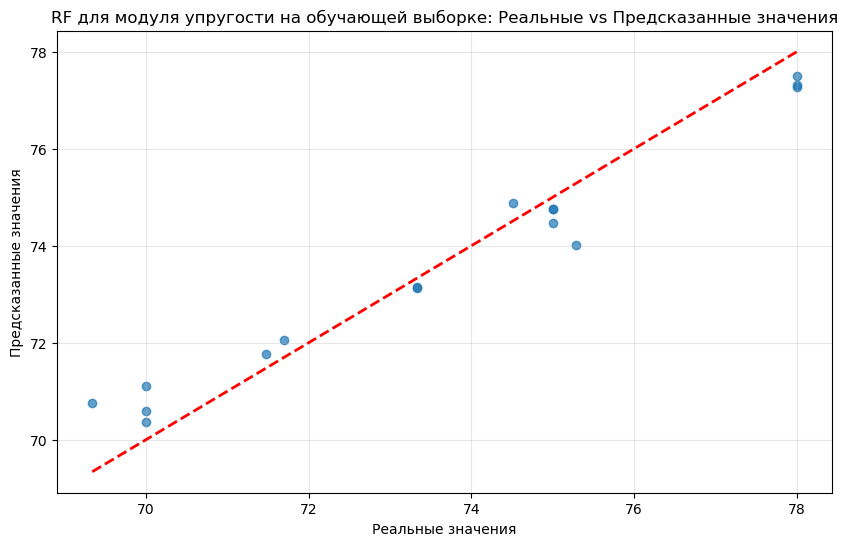

R^2: 0.7505
MAE: 0.6808
MSE: 0.7353


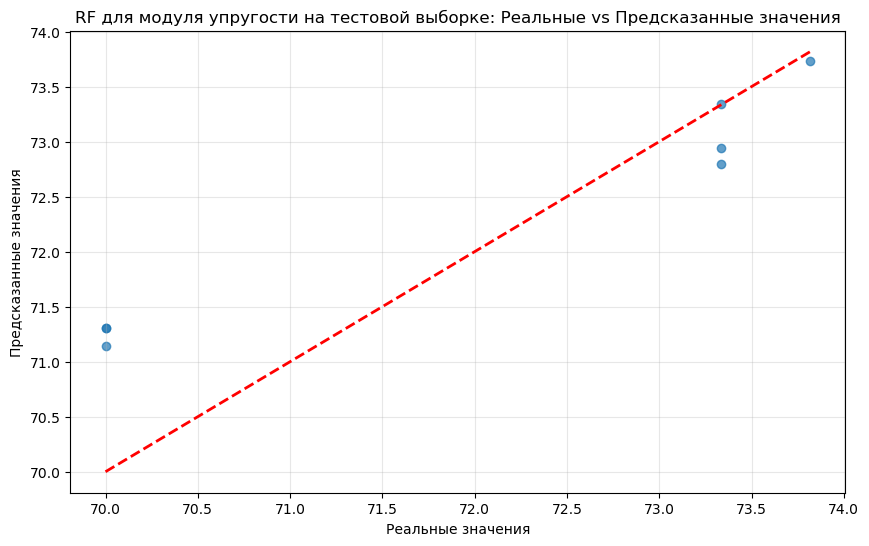

In [24]:
rf_func(X_train, y1_train, X_test, y1_test, 'RF для модуля упругости')

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
R^2: 0.9179
MAE: 0.0867
MSE: 0.0103


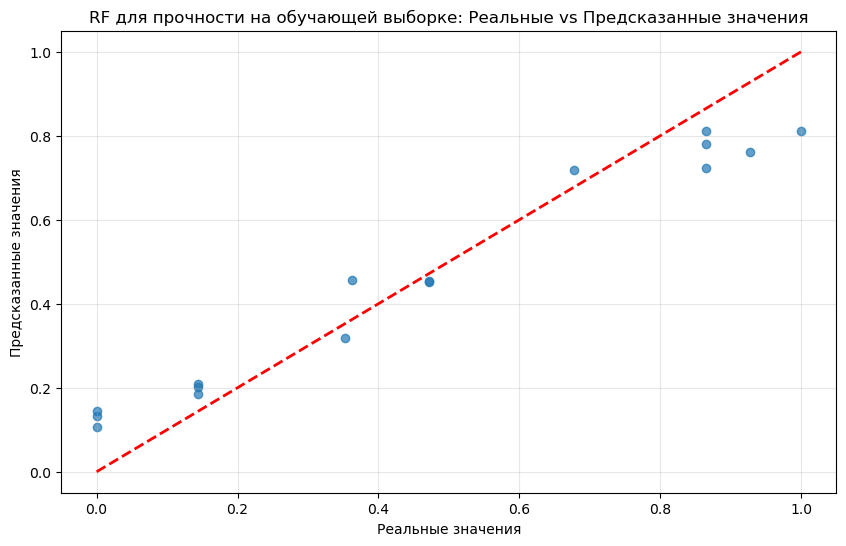

R^2: 0.4572
MAE: 0.1261
MSE: 0.0183


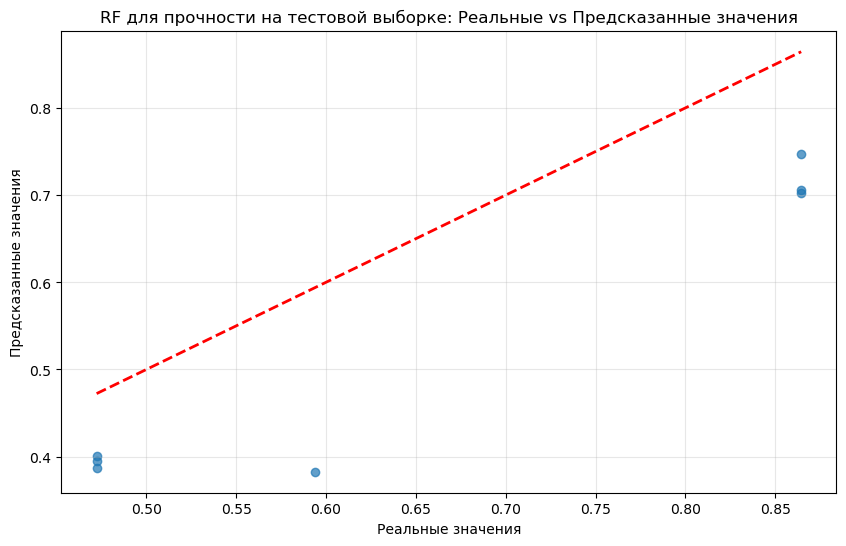

In [13]:
rf_func(X2_train, y2_train, X2_test, y2_test, 'RF для прочности')

**Метод опорных векторов**

In [14]:
def svr_func(X_train, y_train, X_test, y_test, name):
    svr_model = SVR(kernel='rbf') 
    
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'epsilon': [0.01, 0.1, 0.2, 0.3]
    }
    
    grid_search = GridSearchCV(
        estimator=svr_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=10,
        n_jobs=-1,
        verbose=1  # Вывод процесса подбора
    )
    
    grid_search.fit(X_train, y_train.values.ravel())
    
    print("\nЛучшие гиперпараметры:", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
     # Оцениваем на обучающих данных
    y_pred = best_model.predict(X_train)
    show_metric(y_train.values.ravel(),y_pred)
    draw_pred_plt(y_train.values.ravel(),y_pred, name + ' на обучающей выборке')

     # Оцениваем на тестовых данных
    y_pred = best_model.predict(X_test)
    show_metric(y_test.values.ravel(),y_pred)
    draw_pred_plt(y_test.values.ravel(),y_pred, name + ' на тестовой выборке')

Fitting 10 folds for each of 60 candidates, totalling 600 fits

Лучшие гиперпараметры: {'C': 10, 'epsilon': 0.01, 'gamma': 0.01}
R^2: 0.7643
MAE: 0.0922
MSE: 0.0261


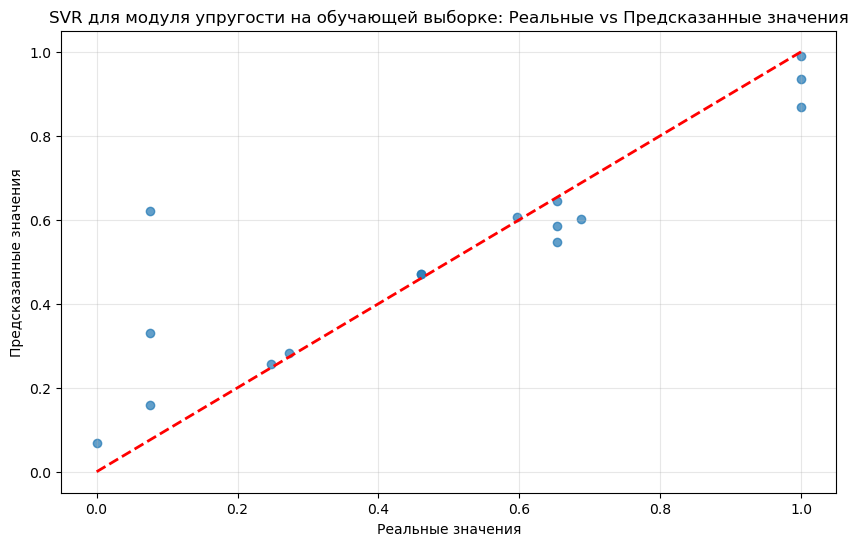

R^2: -1.2571
MAE: 0.2331
MSE: 0.0887


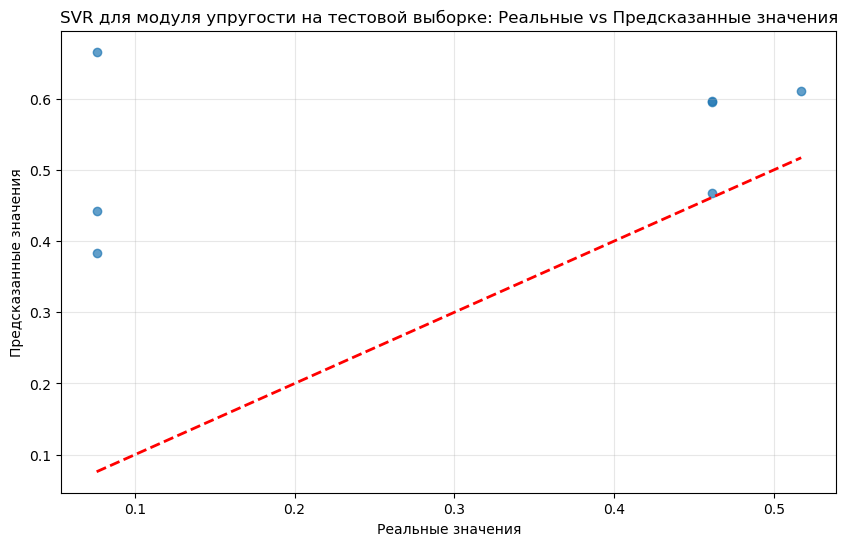

In [15]:
svr_func(X_train, y1_train, X_test, y1_test, 'SVR для модуля упругости')

Fitting 10 folds for each of 60 candidates, totalling 600 fits

Лучшие гиперпараметры: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
R^2: 0.9992
MAE: 0.0096
MSE: 0.0001


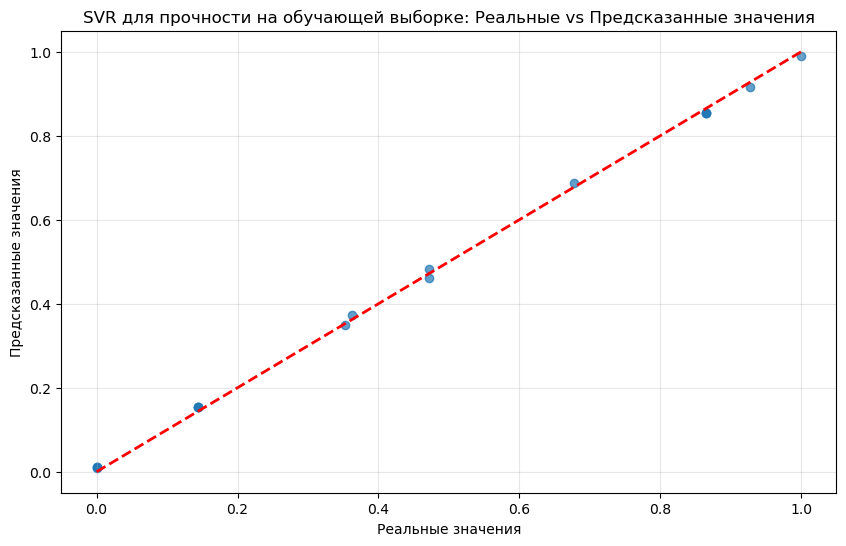

R^2: 0.3399
MAE: 0.1184
MSE: 0.0222


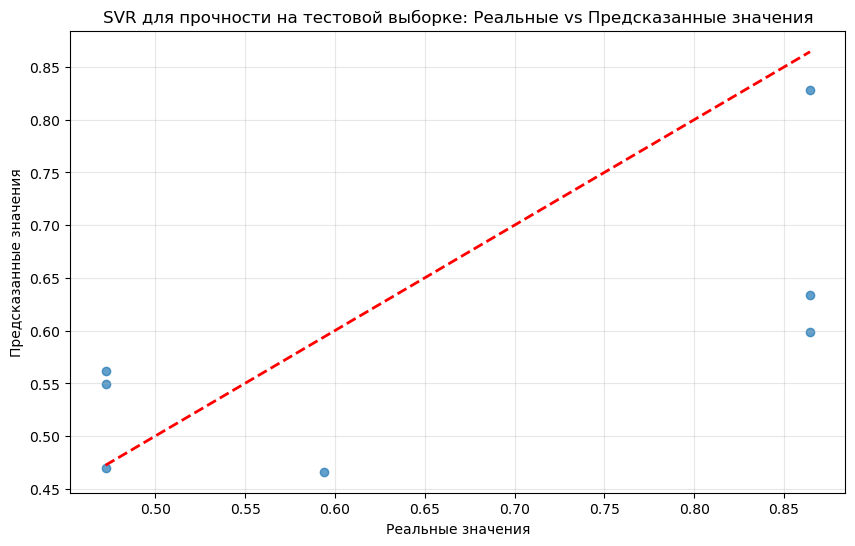

In [16]:
svr_func(X2_train, y2_train, X2_test, y2_test, 'SVR для прочности')

**XGBoost**

In [17]:
def xgb_func(X_train, y_train, X_test, y_test, name):
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,  # Использовать все ядра процессора
        early_stopping_rounds=10,  # Ранняя остановка для предотвращения переобучения
        eval_metric='rmse'  # Метрика для ранней остановки
    )
    
    param_grid = {
        'n_estimators': [5, 10, 50],  # Количество деревьев
        'max_depth': [3, 5, 7],  # Максимальная глубина деревьев
        'subsample': [0.8, 0.9, 1.0],  # Доля образцов для каждого дерева
        'colsample_bytree': [0.8, 0.9, 1.0],  # Доля признаков для каждого дерева
        'gamma': [0, 0.1, 0.2],  # Минимальное снижение потерь для разделения
        'reg_alpha': [0, 0.1],  # L1 регуляризация
        'reg_lambda': [1, 1.5]  # L2 регуляризация
    }
    
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=10,
        n_jobs=-1,
        verbose=1
    )

    
    grid_search.fit(X_train, y_train.values.ravel(), eval_set=[(X_test, y_test)])
    
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
     # Оцениваем на обучающих данных
    y_pred = best_model.predict(X_train)
    show_metric(y_train.values.ravel(),y_pred)
    draw_pred_plt(y_train.values.ravel(),y_pred, name + ' на обучающей выборке')

     # Оцениваем на тестовых данных
    y_pred = best_model.predict(X_test)
    show_metric(y_test.values.ravel(),y_pred)
    draw_pred_plt(y_test.values.ravel(),y_pred, name + ' на тестовой выборке')

Fitting 10 folds for each of 972 candidates, totalling 9720 fits
[0]	validation_0-rmse:0.23091
[1]	validation_0-rmse:0.18544
[2]	validation_0-rmse:0.16816
[3]	validation_0-rmse:0.16722
[4]	validation_0-rmse:0.17451
[5]	validation_0-rmse:0.18464
[6]	validation_0-rmse:0.19487
[7]	validation_0-rmse:0.20276
[8]	validation_0-rmse:0.20966
[9]	validation_0-rmse:0.20604
[10]	validation_0-rmse:0.20365
[11]	validation_0-rmse:0.20436
[12]	validation_0-rmse:0.19959
Лучшие гиперпараметры: {'colsample_bytree': 1.0, 'gamma': 0, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1.0}
R^2: 0.8267
MAE: 0.1164
MSE: 0.0192


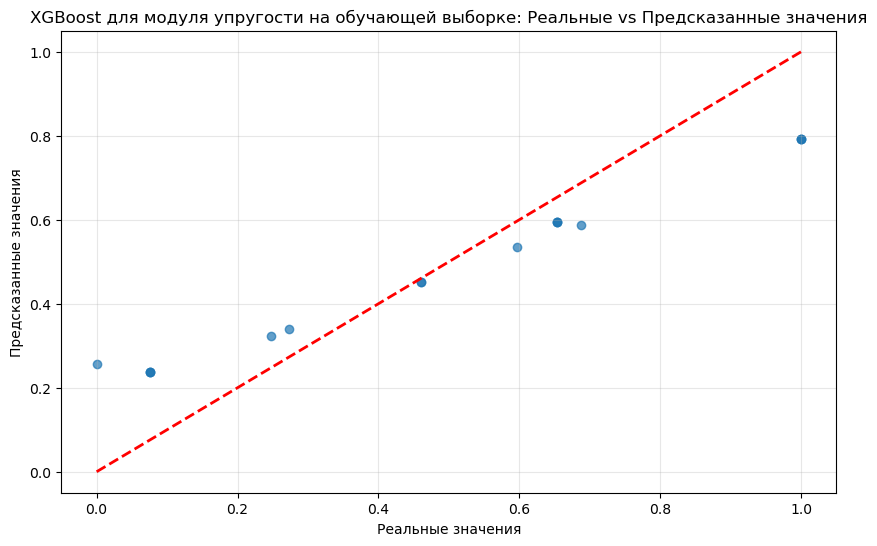

R^2: 0.2887
MAE: 0.1579
MSE: 0.0280


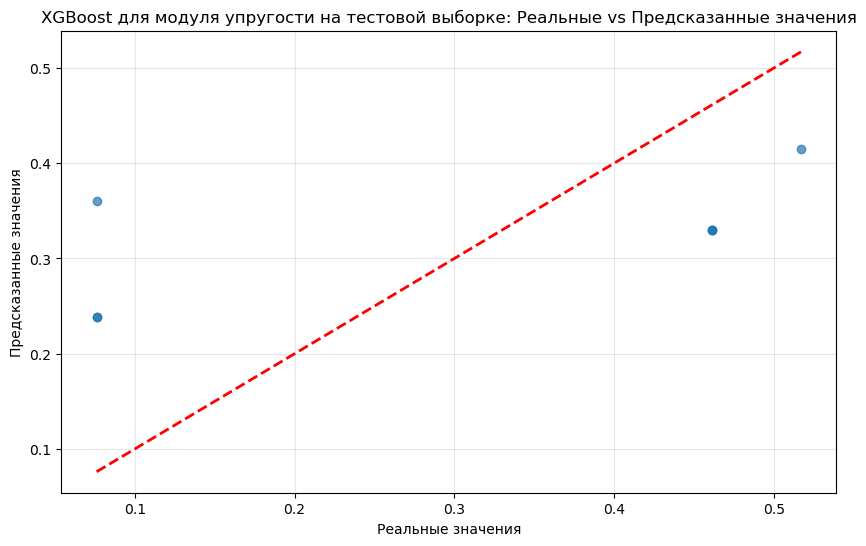

In [18]:
xgb_func(X_train, y1_train, X_test, y1_test, 'XGBoost для модуля упругости')

Fitting 10 folds for each of 972 candidates, totalling 9720 fits
[0]	validation_0-rmse:0.23521
[1]	validation_0-rmse:0.21341
[2]	validation_0-rmse:0.18255
[3]	validation_0-rmse:0.17968
[4]	validation_0-rmse:0.16146
[5]	validation_0-rmse:0.15329
[6]	validation_0-rmse:0.14813
[7]	validation_0-rmse:0.14486
[8]	validation_0-rmse:0.14276
[9]	validation_0-rmse:0.14263
[10]	validation_0-rmse:0.14096
[11]	validation_0-rmse:0.14079
[12]	validation_0-rmse:0.13935
[13]	validation_0-rmse:0.13946
[14]	validation_0-rmse:0.13850
[15]	validation_0-rmse:0.13781
[16]	validation_0-rmse:0.13797
[17]	validation_0-rmse:0.13795
[18]	validation_0-rmse:0.13770
[19]	validation_0-rmse:0.13749
[20]	validation_0-rmse:0.13697
[21]	validation_0-rmse:0.13678
[22]	validation_0-rmse:0.13675
[23]	validation_0-rmse:0.13662
[24]	validation_0-rmse:0.13632
[25]	validation_0-rmse:0.13667
[26]	validation_0-rmse:0.13662
[27]	validation_0-rmse:0.13654
[28]	validation_0-rmse:0.13662
[29]	validation_0-rmse:0.13667
[30]	validation

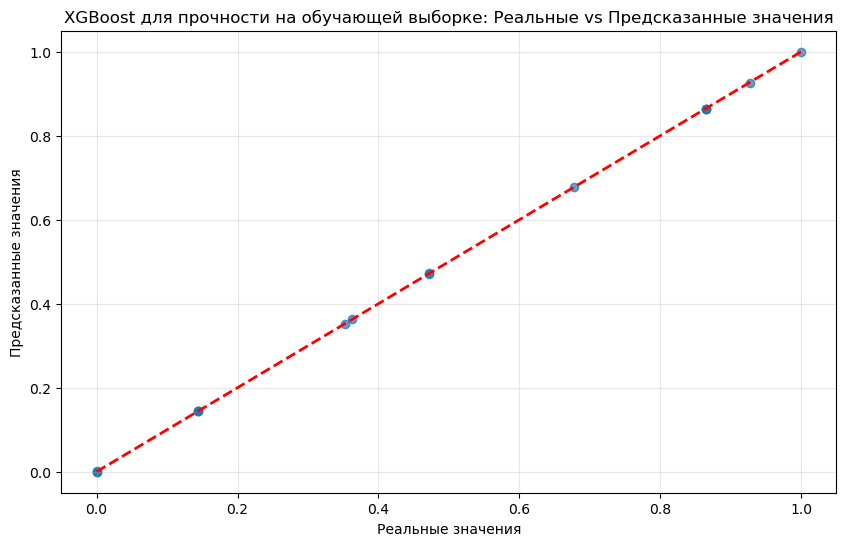

R^2: 0.4486
MAE: 0.0990
MSE: 0.0186


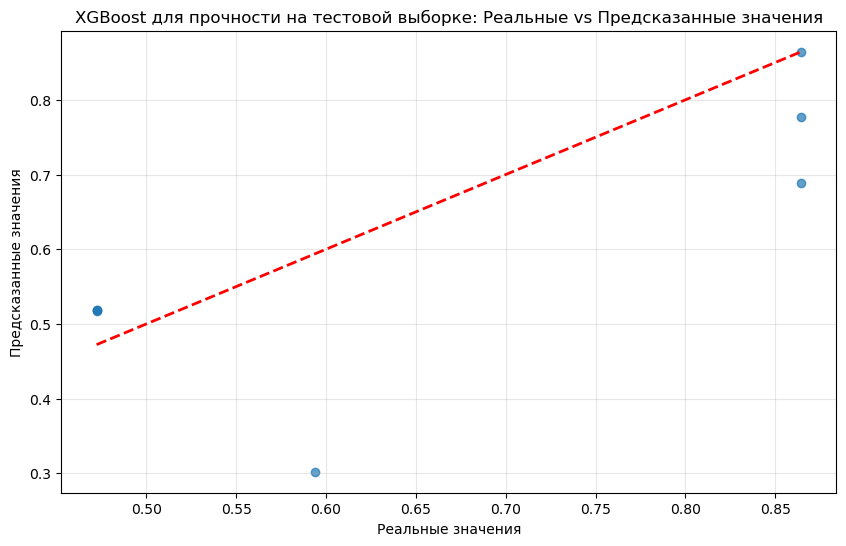

In [19]:
xgb_func(X2_train, y2_train, X2_test, y2_test, 'XGBoost для прочности')

**CatBoost**

In [25]:
def catboost_func(X_train, y_train, X_test, y_test, name):
    cb_model = CatBoostRegressor(
        random_state=42,
        eval_metric='RMSE'  # Метрика для ранней остановки
    )
    
    param_grid = {
        'n_estimators': [5, 10, 50],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
     }
    
    grid_search = GridSearchCV(
        estimator=cb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=10,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train.values.ravel(), eval_set=[(X_test, y_test)])

    print("Лучшие гиперпараметры:", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
     # Оцениваем на обучающих данных
    y_pred = best_model.predict(X_train)
    show_metric(y_train.values.ravel(),y_pred)
    draw_pred_plt(y_train.values.ravel(),y_pred, name + ' на обучающей выборке')

     # Оцениваем на тестовых данных
    y_pred = best_model.predict(X_test)
    show_metric(y_test.values.ravel(),y_pred)
    draw_pred_plt(y_test.values.ravel(),y_pred, name + ' на тестовой выборке')

    return best_model

0:	learn: 2.7565287	test: 2.3986596	best: 2.3986596 (0)	total: 754us	remaining: 37ms
1:	learn: 2.6373725	test: 2.3378722	best: 2.3378722 (1)	total: 1.3ms	remaining: 31.2ms
2:	learn: 2.4881087	test: 2.2192130	best: 2.2192130 (2)	total: 1.51ms	remaining: 23.6ms
3:	learn: 2.4194340	test: 2.1961502	best: 2.1961502 (3)	total: 1.72ms	remaining: 19.7ms
4:	learn: 2.2850963	test: 2.0389479	best: 2.0389479 (4)	total: 1.95ms	remaining: 17.5ms
5:	learn: 2.1469274	test: 1.8969174	best: 1.8969174 (5)	total: 2.21ms	remaining: 16.2ms
6:	learn: 2.0360707	test: 1.7774031	best: 1.7774031 (6)	total: 2.45ms	remaining: 15ms
7:	learn: 1.9337995	test: 1.7025630	best: 1.7025630 (7)	total: 2.65ms	remaining: 13.9ms
8:	learn: 1.8042741	test: 1.5956012	best: 1.5956012 (8)	total: 2.87ms	remaining: 13.1ms
9:	learn: 1.7377963	test: 1.5451253	best: 1.5451253 (9)	total: 3.1ms	remaining: 12.4ms
10:	learn: 1.6408957	test: 1.4554527	best: 1.4554527 (10)	total: 3.31ms	remaining: 11.7ms
11:	learn: 1.5974520	test: 1.4533528	

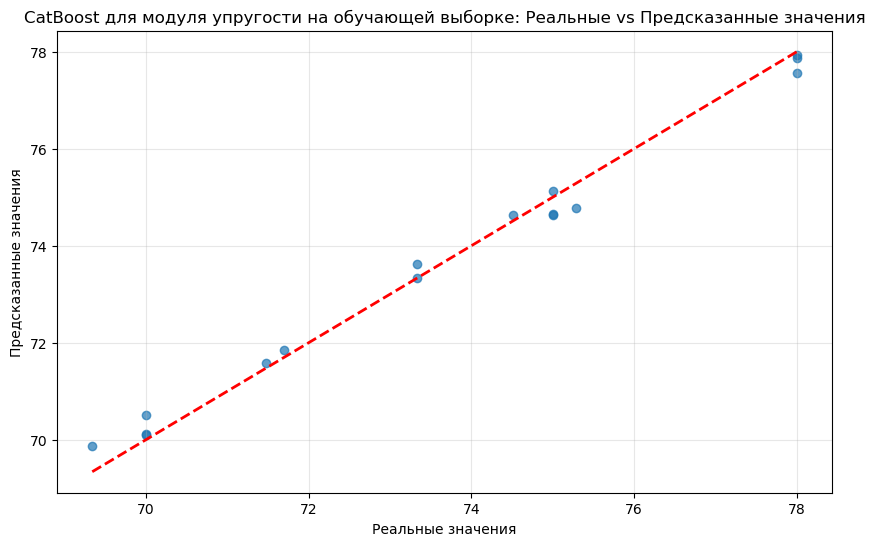

R^2: 0.8606
MAE: 0.6078
MSE: 0.4107


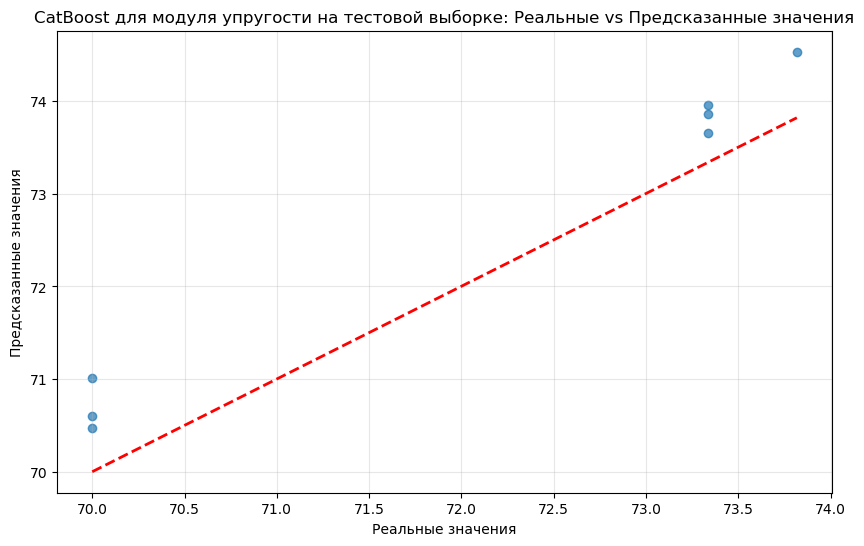

In [26]:
catboost_model_1 = catboost_func(X_train, y1_train, X_test, y1_test, 'CatBoost для модуля упругости')

0:	learn: 461.3632235	test: 357.5602254	best: 357.5602254 (0)	total: 563us	remaining: 27.6ms
1:	learn: 435.5708162	test: 347.3788725	best: 347.3788725 (1)	total: 1.01ms	remaining: 24.3ms
2:	learn: 411.1073065	test: 330.2658239	best: 330.2658239 (2)	total: 1.33ms	remaining: 20.9ms
3:	learn: 389.1340202	test: 315.3420503	best: 315.3420503 (3)	total: 1.65ms	remaining: 19ms
4:	learn: 364.9089928	test: 313.0051972	best: 313.0051972 (4)	total: 2ms	remaining: 18ms
5:	learn: 346.0424260	test: 315.7085721	best: 313.0051972 (4)	total: 2.43ms	remaining: 17.8ms
6:	learn: 332.3682951	test: 316.2008405	best: 313.0051972 (4)	total: 2.75ms	remaining: 16.9ms
7:	learn: 325.2436196	test: 320.9712148	best: 313.0051972 (4)	total: 2.97ms	remaining: 15.6ms
8:	learn: 304.7290060	test: 300.1211116	best: 300.1211116 (8)	total: 3.33ms	remaining: 15.2ms
9:	learn: 288.5853514	test: 292.4514993	best: 292.4514993 (9)	total: 3.67ms	remaining: 14.7ms
10:	learn: 274.4810949	test: 286.3114803	best: 286.3114803 (10)	tota

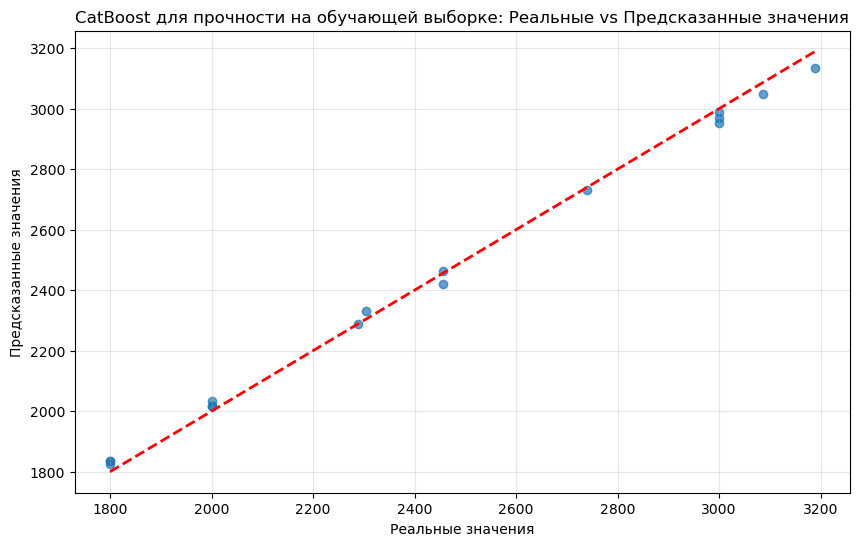

R^2: 0.6426
MAE: 119.8540
MSE: 23172.8043


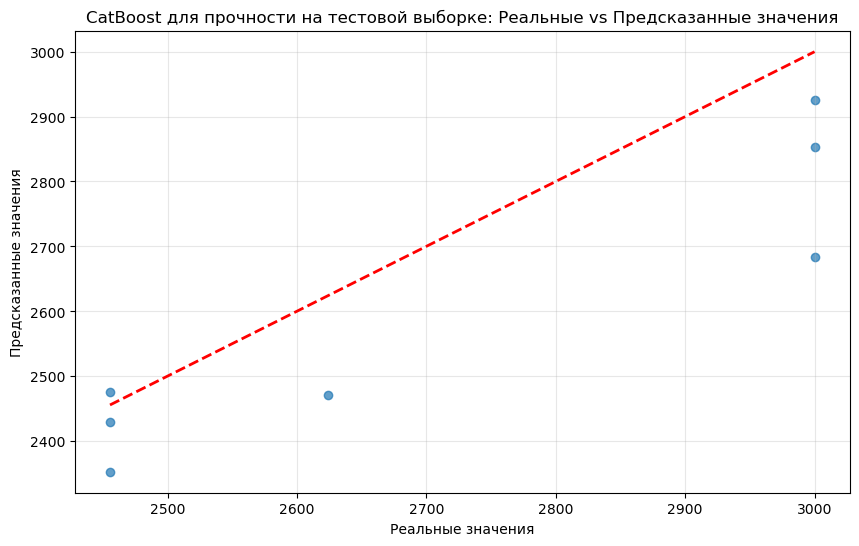

In [27]:
catboost_model_2 = catboost_func(X_train, y2_train, X_test, y2_test, 'CatBoost для прочности')

**KNN Регрессия**

In [153]:
def knn_func(X_train, y_train, X_test, y_test, name):
    
    knn =  KNeighborsRegressor()
    
    param_grid = {
        'n_neighbors': [1, 2],  # Количество соседей
        'weights': ['uniform', 'distance'],  # Весовая функция
    }
    
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=10,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train.values.ravel())
    
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
     # Оцениваем на обучающих данных
    y_pred = best_model.predict(X_train)
    show_metric(y_train.values.ravel(),y_pred)
    draw_pred_plt(y_train.values.ravel(),y_pred, name + ' на обучающей выборке')

     # Оцениваем на тестовых данных
    y_pred = best_model.predict(X_test)
    show_metric(y_test.values.ravel(),y_pred)
    draw_pred_plt(y_test.values.ravel(),y_pred, name + ' на тестовой выборке')

Лучшие гиперпараметры: {'n_neighbors': 2, 'weights': 'distance'}
R^2: 1.0000
MAE: 0.0000
MSE: 0.0000


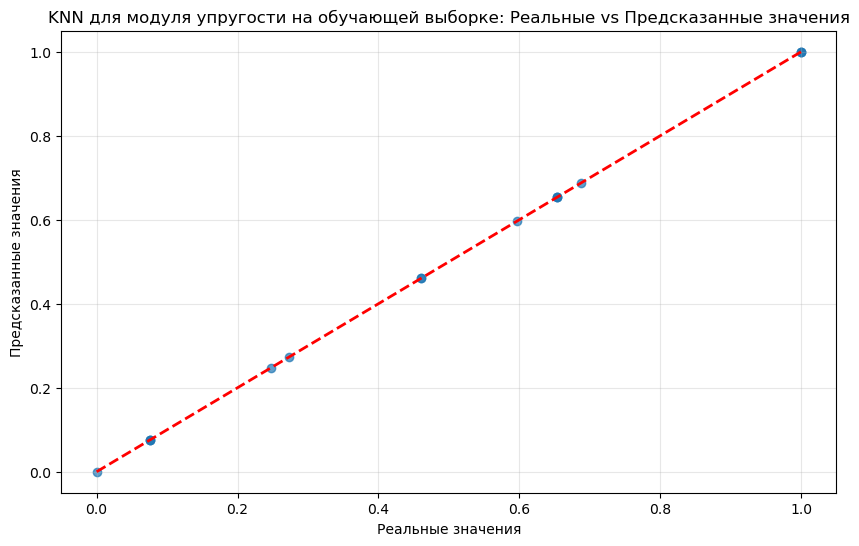

R^2: 0.0230
MAE: 0.1462
MSE: 0.0384


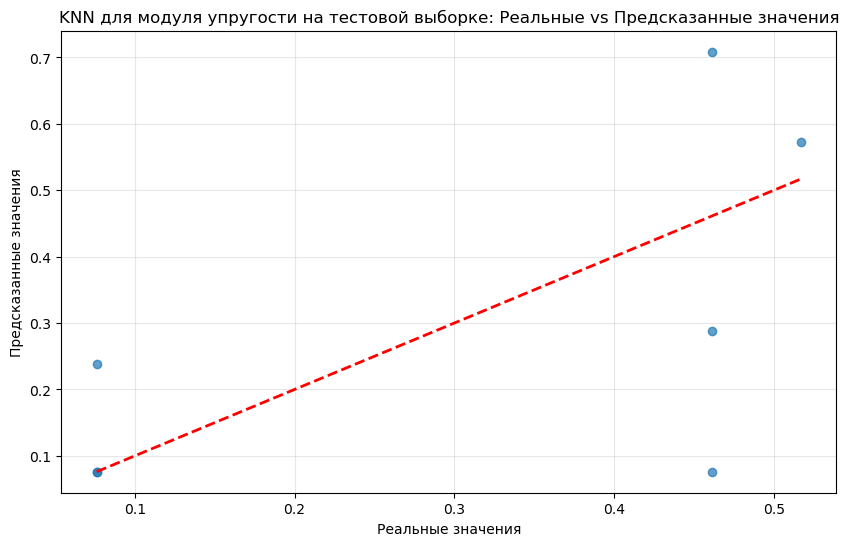

In [154]:
knn_func(X_train, y1_train, X_test, y1_test, 'KNN для модуля упругости')

Лучшие гиперпараметры: {'n_neighbors': 2, 'weights': 'distance'}
R^2: 1.0000
MAE: 0.0000
MSE: 0.0000


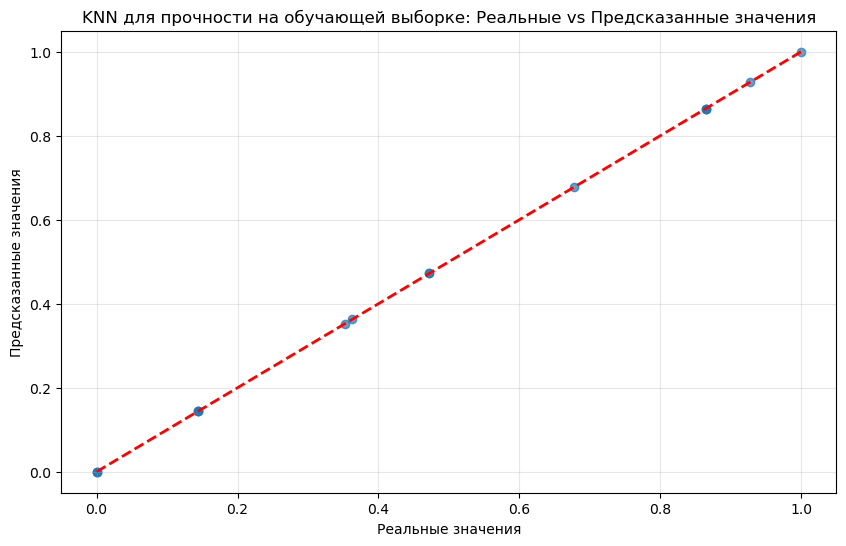

R^2: -0.1284
MAE: 0.1514
MSE: 0.0380


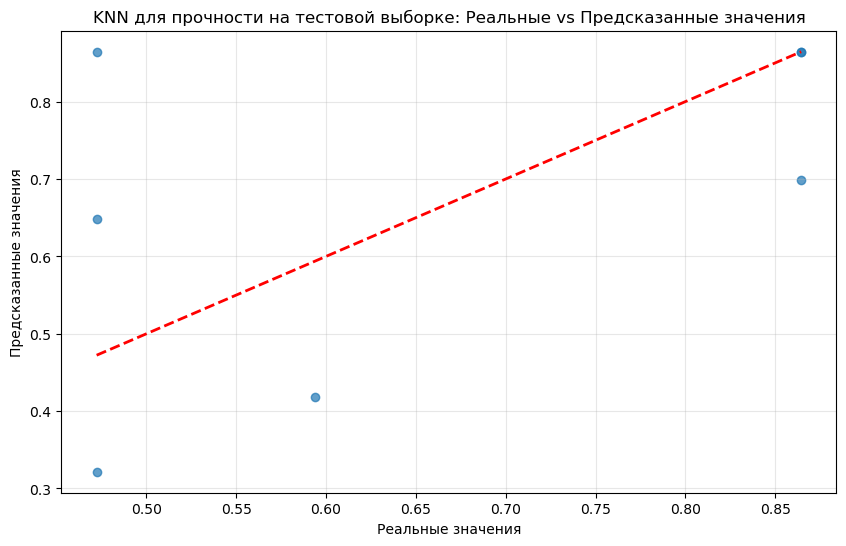

In [155]:
knn_func(X_train, y2_train, X_test, y2_test, 'KNN для прочности')

**Многослойный перцептрон**

In [3]:
#Определние тестовой и обучающей выборок
X_for_MLP = pd.read_excel('X_for_MLP.xlsx')
y3 = pd.read_excel('y3.xlsx')
X3_train, X3_test, y3_train, y3_test = train_test_split(X_for_MLP, y3, test_size=0.3, random_state=42)

In [149]:
X_for_MLP

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.625107,0.438928,0.912803,0.000000,0.711831,0.000000,0.864468,0.555556,0,0.166667,0.000000
1,0.625107,0.450658,0.584256,0.229622,0.416197,0.000000,0.864468,0.555556,0,0.166667,0.434783
2,0.538593,0.446546,0.584256,0.229622,0.416197,0.000000,0.864468,0.555556,0,0.166667,0.565217
3,0.279051,0.495066,0.584256,0.229622,0.416197,0.000000,0.864468,0.555556,0,0.166667,1.000000
4,0.250214,0.271382,0.584256,0.229622,0.416197,0.212500,0.000000,0.000000,0,0.500000,0.000000
5,0.336727,0.562500,0.912803,0.000000,0.711831,0.212500,0.000000,0.000000,0,0.500000,0.434783
6,0.826972,1.000000,0.912803,0.000000,0.711831,1.000000,0.144078,1.000000,0,0.500000,0.565217
7,1.000000,0.598684,0.912803,0.000000,0.711831,1.000000,0.144078,1.000000,0,0.500000,1.000000
8,0.394403,0.511513,0.912803,0.000000,0.711831,0.325000,0.472256,0.555556,0,0.833333,0.434783
9,0.480917,0.298520,0.912803,0.000000,0.711831,0.325000,0.472256,0.555556,0,0.833333,0.565217


In [150]:
y3

,Соотношение матрица-наполнитель
0,0.099781
1,0.452019
2,0.450704
3,0.374299
4,0.371161
5,0.754744
6,0.745235
7,0.509177
8,0.000000
9,0.509177


R^2: 0.1841
MAE: 0.1606
MSE: 0.0358


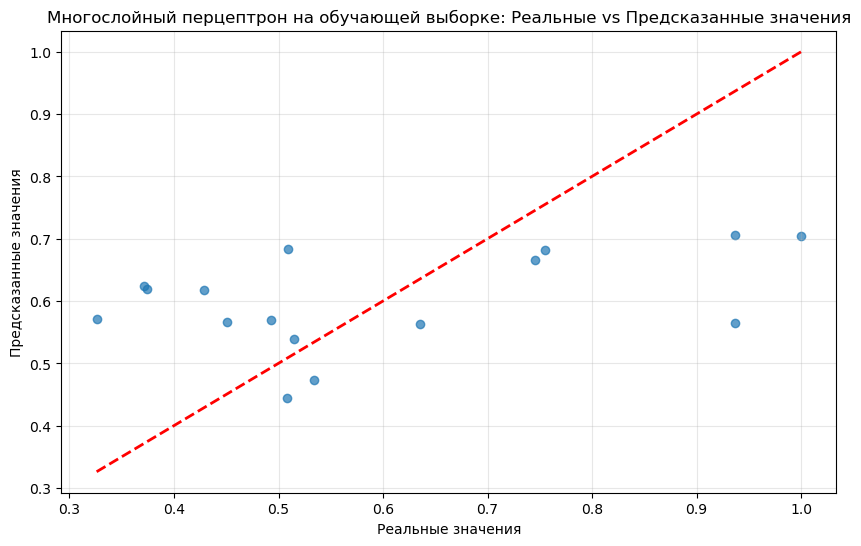

R^2: -0.9807
MAE: 0.3179
MSE: 0.1438


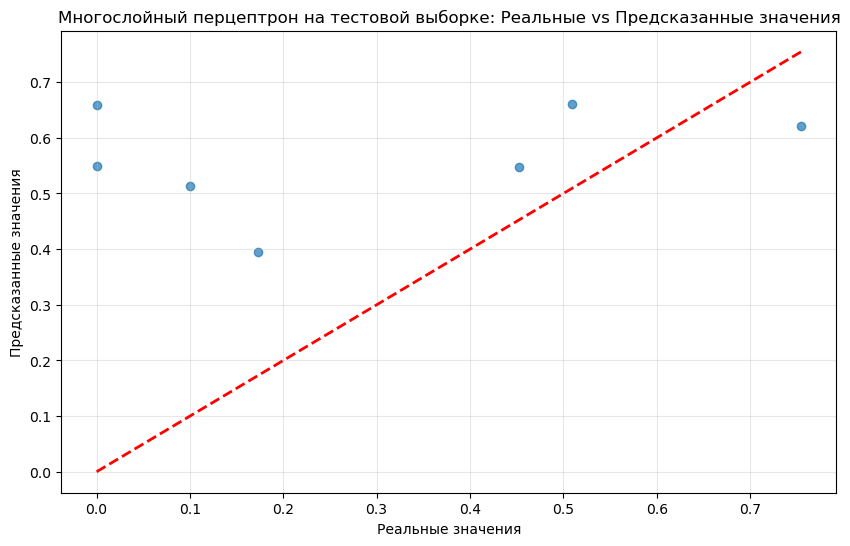

In [32]:
# Создание модели
mlp = Pipeline([
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(100, 50, 50),
        activation='tanh',
        solver='sgd',
        max_iter=100000,
        random_state=42,
        learning_rate= 'adaptive',
        warm_start=True
    ))
])

# Обучение и предсказание
mlp.fit(X3_train, y3_train.values.ravel())

# Оцениваем на обучающих данных
y_pred = mlp.predict(X3_train)
show_metric(y3_train.values.ravel(),y_pred)
draw_pred_plt(y3_train.values.ravel(),y_pred, 'Многослойный перцептрон на обучающей выборке')

# Оцениваем на тестовых данных
y_pred = mlp.predict(X3_test)
show_metric(y3_test.values.ravel(),y_pred)
draw_pred_plt(y3_test.values.ravel(),y_pred, 'Многослойный перцептрон на тестовой выборке')

**Сохранение наиболее успешной модели**

In [28]:
joblib.dump(catboost_model_2, 'catboost_model_2.pkl')

['catboost_model_2.pkl']

In [29]:
joblib.dump(catboost_model_1, 'catboost_model_1.pkl')

['catboost_model_1.pkl']